<a href="https://colab.research.google.com/github/Naomiweinberger/Hate-Speech/blob/main/Masking_a_raster_using_a_shapefile_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  import os 
  if not os.path.exists('mamba'): goToException
  
  print('MAMBA OK')
  
  from osgeo import gdal 
  print(gdal.VersionInfo())
  !gdalinfo --version  

except:
  print('NO MAMBA')

  !pip install -q condacolab
  
  import condacolab
  condacolab.install()

  !mamba install -q gdal=3.4.1
    
  with open('mamba','w') as f: 
    pass

  ### RUNTIME WILL CRASH HERE. WHEN IT DOES:
      ### RUNTIME >> RUN ALL 
  from osgeo import gdal 
  print(gdal.VersionInfo())
  !gdalinfo --version


MAMBA OK
3040100
GDAL 3.4.1, released 2021/12/27


In [ ]:
### https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html

!pip install -q fiona
import fiona

!pip install -q rasterio
import rasterio
import rasterio.mask

import matplotlib.pyplot as plt
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 13.2 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade gdown -q

tncParking_zip = '1_67WOXuUoQYaF15-BbFE_0AXkpRx8rLa&confirm=t'

!gdown $tncParking_zip

!unzip TNC_PARKING.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 10.5 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1_67WOXuUoQYaF15-BbFE_0AXkpRx8rLa
To: /content/TNC_PARKING.zip
100% 2.80M/2.80M [00:00<00:00, 60.3MB/s]
Archive:  TNC_PARKING.zip
 extracting: TNC_PARKING/notParlingLots.cpg  
  inflating: TNC_PARKING/notParlingLots.dbf  
  inflating: TNC_PARKING/notParlingLots.prj  
  inflating: TNC_PARKING/notParlingLots.qmd  
  inflating: TNC_PARKING/notParlingLots.shp  
  inflating: TNC_PARKING/notParlingLots.shx  
 extracting: TNC_PARKING/yesParkingLots.cpg  
  inflating: TNC_PARKING/yesParkingLots.dbf  
  inflating: TNC_PARKING/yesParkingLots.prj  
  inflating: TNC_PARKING/yesParkingLots.qmd  
  inflating: TNC_PARKING/yesParkingLots.shp  
  inflating: TNC_PARKING/yesParkingLots.shx  


In [ ]:
fullRaster = '17jmAmQD_UM6QtnFIazDVM0QGF1i-SbY3&confirm=t'

!gdown $fullRaster

Downloading...
From: https://drive.google.com/uc?id=17jmAmQD_UM6QtnFIazDVM0QGF1i-SbY3
To: /content/fullRasterMerge.TIF
100% 695M/695M [00:05<00:00, 122MB/s]


In [ ]:
parkingSHP = 'TNC_PARKING/yesParkingLots.shp'
notParkSHP = 'TNC_PARKING/notParlingLots.shp'

parkingTIF = 'fullRasterMerge.TIF'

In [ ]:
def getCoords(shapeObj):
  coords = shapeObj['coordinates'][0]
  x,y = zip(*coords)
  return x,y


def plotBoundaries(inputSHP):
    # Read Shape file
  with fiona.open(inputSHP, 'r') as shapefile:
      shapes = [feature["geometry"] for feature in shapefile]
      shapes = [ i for i in shapes if i is not None]

  plt.figure(figsize=(12,7))

  for idx,shape in enumerate(shapes):    
    x,y = getCoords( shapes[idx] )  
    plt.plot(x,y)

  plt.title('PARKING LOT BOUNDARIES')
  
  plt.show()  


def MAX(arr):
  for idx,row in enumerate(arr):
    for jdx,col in enumerate(row):
      if col > 308:
        arr[idx][jdx] = 308
  return arr


def normalize(arr):
    ''' Function to normalize an input array to 0-1 '''
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)
  

def showRSTR(rasterPath, showBand4=0, w=12,h=7):
  dataset = gdal.Open(rasterPath)

  print(f'dataset.RasterCount: {dataset.RasterCount}')

  numBands = int(dataset.RasterCount)

  bandNames = []

  for band in range(1, numBands+1):
    bandx = locals()[f'band{band}'] = dataset.GetRasterBand(band)
    bx    = locals()[f'b{band}']    = locals()[f'band{band}'].ReadAsArray()
    bx_MAX  = locals()[f'b{band}_MAX']  = MAX(locals()[f'b{band}'])
    bx_N    = locals()[f'b{band}_N']    = normalize(locals()[f'b{band}_MAX'])


    bandNames.append(locals()[f'b{band}_N'])

  if not showBand4 and len(bandNames) >= 4:
    bandNames = bandNames[:-1]

  img = np.dstack(bandNames)

  fig = plt.figure(figsize=(w,h))

  plt.imshow(img)

  fig.set_size_inches(30.,18.)

  fig.savefig('300dpi.png', dpi=300, bbox_inches='tight',transparent=True, pad_inches=0) 


def clipRaster(inputSHP, inputTIF, filename='clipped_output.png', showClippedRaster=0):

  # Read Shape file
  with fiona.open(inputSHP, 'r') as shapefile:
      shapes = [feature["geometry"] for feature in shapefile]
      shapes = [ i for i in shapes if i is not None]

  # read imagery file
  with rasterio.open(inputTIF) as src:
      out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
      out_meta = src.meta

  # Save clipped imagery
  out_meta.update(  {"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform} )

  with rasterio.open(filename, 'w', **out_meta) as dest:
      dest.write(out_image)


  if showClippedRaster:
    showRSTR(filename)


def clipRasterToPNG(inputSHP, inputTIF, filename='clipped_output_fullMerge', showClippedRaster=0):
  if not os.path.exists('/content/OUTPUT/fullMerge/'): os.makedirs('/content/OUTPUT/fullMerge/')

  # Read Shape file
  with fiona.open(inputSHP, 'r') as shapefile:
      shapes = [feature["geometry"] for feature in shapefile]
      shapes = [ i for i in shapes if i is not None]

  # read imagery file
  with rasterio.open(inputTIF) as src:
      out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
      out_meta = src.meta

  # Save clipped imagery
  out_meta.update(  {"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform} )

  


  with rasterio.open('/content/OUTPUT/fullMerge/' + filename +'.tif', 'w', **out_meta) as dest:
      dest.write(out_image)



  ### GDAL TRANSLATE OPTIONS
  kwargs_gdal = {
      'format': 'PNG',
      'outputType': gdal.GDT_Byte,
  }


  gdal.Translate(
      '/content/OUTPUT/fullMerge/' + filename +'.png' , 
      '/content/OUTPUT/fullMerge/' + filename +'.tif' , 
      **kwargs_gdal 
  )
  

def clipRasterPerShape(inputSHP, inputTIF, filename='clipped_output', showClippedRaster=0):
  if not os.path.exists('/content/OUTPUT/TIF/'): os.makedirs('/content/OUTPUT/TIF/')
  if not os.path.exists('/content/OUTPUT/PNG/'): os.makedirs('/content/OUTPUT/PNG/')

  ### READ SHAPE FILE, EXTRACT GEOMETRIES
  with fiona.open(inputSHP, 'r') as shapefile:
      shapes = [feature["geometry"] for feature in shapefile]
      shapes = [ i for i in shapes if i is not None]
  

  ### FOR EACH GEOMETRY IN shapes 
  ### OUTPUT A CROPPED-TIF, READ BACK IN AND OUTPUT AS A PNG
  for idx,SHAPE in enumerate(shapes[0:]):
    
    outputFile = f'{idx}_{filename}'
    
    ### READ RASTER FILE
    with rasterio.open(inputTIF) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes[idx:idx+1], crop=True)
        out_meta = src.meta


    ### OUTPUT TO 
    out_meta.update(  {"driver": "GTiff",
                      "height": out_image.shape[1],
                      "width": out_image.shape[2],
                      "transform": out_transform} )
    
    
    with rasterio.open('/content/OUTPUT/TIF/' + outputFile +'.tif', 'w', **out_meta) as dest:
        dest.write(out_image)


    ### GDAL TRANSLATE OPTIONS
    kwargs_gdal = {
        'format': 'PNG',
        'outputType': gdal.GDT_Byte,
    }


    gdal.Translate(
        '/content/OUTPUT/PNG/' + outputFile +'.png' , 
        '/content/OUTPUT/TIF/' + outputFile +'.tif' , 
        **kwargs_gdal 
    )
    
    print(f'saved {outputFile}')


    # if showClippedRaster:
    #   showRSTR(filename)



def clipRasterPerShapeAndLabel(inputSHP, inputTIF, label, filename='clipped_output', showClippedRaster=0):
  pngOutputPath = f'/content/OUTPUT/PNG/{label}/'
  tifOutputPath = f'/content/OUTPUT/TIF/{label}/'

  if not os.path.exists(tifOutputPath): os.makedirs(tifOutputPath)
  if not os.path.exists(pngOutputPath): os.makedirs(pngOutputPath)

  ### READ SHAPE FILE, EXTRACT GEOMETRIES
  with fiona.open(inputSHP, 'r') as shapefile:
      shapes = [feature["geometry"] for feature in shapefile]
      shapes = [ i for i in shapes if i is not None]
  

  ### FOR EACH GEOMETRY IN shapes 
  ### OUTPUT A CROPPED-TIF, READ BACK IN AND OUTPUT AS A PNG
  for idx,SHAPE in enumerate(shapes[0:]):
    
    outputFile = f'{idx}_{filename}'
    
    ### READ RASTER FILE
    with rasterio.open(inputTIF) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes[idx:idx+1], crop=True)
        out_meta = src.meta


    ### OUTPUT TO 
    out_meta.update(  {"driver": "GTiff",
                      "height": out_image.shape[1],
                      "width": out_image.shape[2],
                      "transform": out_transform} )
    
    
    with rasterio.open(tifOutputPath + outputFile + '.tif', 'w', **out_meta) as dest:
        dest.write(out_image)


    ### GDAL TRANSLATE OPTIONS
    kwargs_gdal = {
        'format': 'PNG',
        'outputType': gdal.GDT_Byte,
    }


    gdal.Translate(
        pngOutputPath + outputFile +'.png' , 
        tifOutputPath + outputFile +'.tif' , 
        **kwargs_gdal 
    )
    
    print(f'saved {outputFile}')


    # if showClippedRaster:
    #   showRSTR(filename)




In [ ]:
### TEST FUNCTIONS WITH SAMPLE RASTER AND MAIN RASTER/SHP

if not 'brain_398.tif' in os.listdir():
  !wget -q https://people.math.sc.edu/Burkardt/data/tif/brain_398.tif
  brainRaster = 'brain_398.tif'

showRSTR(brainRaster)

showRSTR(parkingTIF)

plotBoundaries(parkingSHP)

clipRaster(parkingSHP, parkingTIF)

clipRasterPerShape(parkingSHP, parkingTIF)

clipRasterToPNG(parkingSHP, parkingTIF)


In [ ]:
# !rm -r /content/OUTPUT/TIF

### CREATE PNGs FOR BOTH CATEGORIES
clipRasterPerShapeAndLabel(notParkSHP, parkingTIF, 'notPL')
clipRasterPerShapeAndLabel(parkingSHP, parkingTIF, 'yesPL')

In [ ]:
from google.colab import files

zipAndDownloadOUTPUT = 0

if zipAndDownloadOUTPUT:
  !zip -r /content/OUTPUT.zip /content/OUTPUT
  files.download("/content/OUTPUT.zip")

In [ ]:
outputZip = 'PNGs.zip'
inputFolder = '/content/OUTPUT/PNG'
# !zip -r $outputZip $inputFolder
files.download(outputZip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##**`DEBUGGING SECTION`**

In [ ]:

def showR(rasterPath, showBand4=0, w=12,h=7, showSeparateBands=0):
  dataset = gdal.Open(rasterPath)

  print(f'dataset.RasterCount: {dataset.RasterCount}')

  numBands = int(dataset.RasterCount)

  bandNames = []

  for band in range(1, numBands+1):
    bandx   = locals()[f'band{band}']   = dataset.GetRasterBand(band)
    bx      = locals()[f'b{band}']      = locals()[f'band{band}'].ReadAsArray()
    bx_MAX  = locals()[f'b{band}_MAX']  = MAX(locals()[f'b{band}'])
    bx_N    = locals()[f'b{band}_N']    = normalize(locals()[f'b{band}_MAX'])

    bandNames.append(locals()[f'b{band}_N'])

  if not showBand4 and len(bandNames) >= 4:
    bandNames = bandNames[:-1]

  if showSeparateBands:
    for idx,i in enumerate(bandNames):
      # print(idx+1, i[0:10])
      pass

    for idx,i in enumerate(bandNames):
      # print(i[0:20])
      if idx<len(bandNames)-1:
        # list1, list2 = bandNames[idx], bandNames[idx+1]
        
        truth = bandNames[idx]==bandNames[idx+1]
        # print(f'bandNames[{idx}]==bandNames[{idx+1}]', 'truth' )
        
        flatTruth = truth.flatten(order='C')
        # print(f'all(flatTruth): {all(flatTruth)} ')
        
        
      f = plt.figure(figsize=(w,h))
      plt.imshow(i)
      plt.title(f'BAND {idx+1}')
      plt.show()

  
  
  fig = plt.figure(figsize=(w,h))

  img = np.dstack(bandNames)

  plt.imshow(img)

  # plt.show()
  # fig.savefig(r'geotiff.png')  
  # plt.savefig('OTPUT.png')
  fig.set_size_inches(30.,18.)
  plt.savefig('100dpi.png', dpi=100)
  fig.savefig('200dpi.png', dpi=200)


dataset.RasterCount: 4


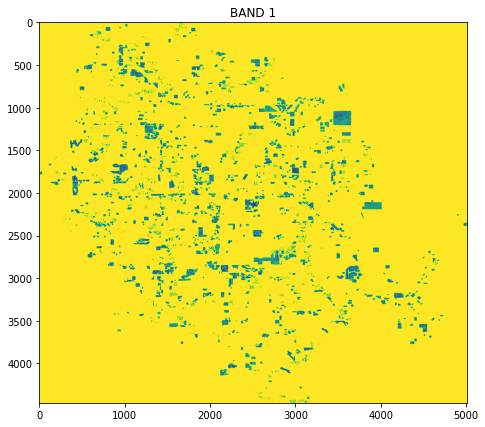

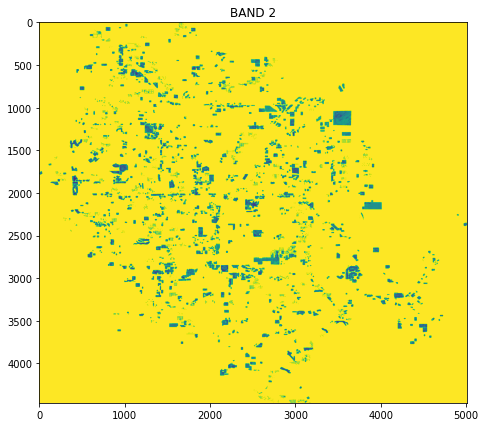

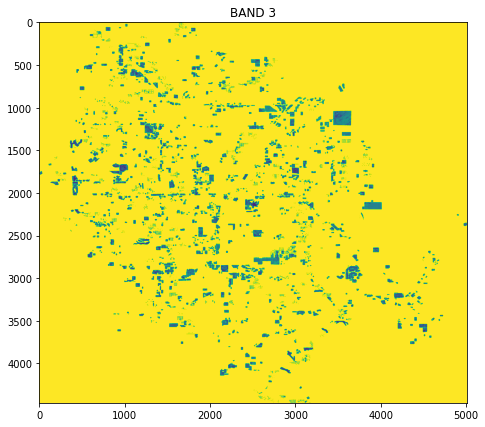

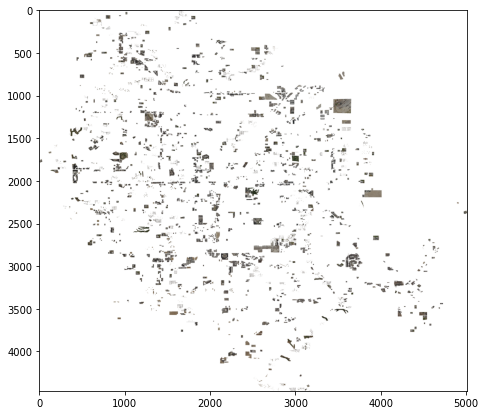

In [ ]:
# showR(brainRaster, showSeparateBands=1)
showR(parkingTIF, showSeparateBands=1)

In [ ]:
def MAX(arr):
  for idx,row in enumerate(arr):
    for jdx,col in enumerate(row):
      if col > 308:
        arr[idx][jdx] = 308
  return arr

data = gdal.Open(parkingTIF)
band1 = data.GetRasterBand(1)
b1 = band1.ReadAsArray()

# 1.79e+308
b1_N = MAX(b1)
b1_N = normalize(b1_N)
b1_list = b1_N.tolist()

b1_flat = b1_N.flatten(order='C')

print(f'len(b1_flat): {len(b1_flat)}')
print(f'len(set(b1_flat)): {len(set(b1_flat))}')
print(f'set(b1_flat): {set(b1_flat)}')

for row in b1_list: 
  print(row[0:100])

In [ ]:

# raster = rasterio.open(parkingTIF)
# print(raster.)
print(raster.driver)
print(raster.count)
print(raster.meta)

band1 = raster.read(1)

plt.imshow(band1)

print()

dir(raster)


In [ ]:
def clipRasterToPNG(inputSHP, inputTIF, filename='clipped_output_fullMerge', showClippedRaster=0):
  if not os.path.exists('/content/OUTPUT/fullMerge/'): os.makedirs('/content/OUTPUT/fullMerge/')

  # Read Shape file
  with fiona.open(inputSHP, 'r') as shapefile:
      shapes = [feature["geometry"] for feature in shapefile]
      shapes = [ i for i in shapes if i is not None]

  # read imagery file
  with rasterio.open(inputTIF) as src:
      out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
      out_meta = src.meta

  # Save clipped imagery
  out_meta.update(  {"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform} )

  


  with rasterio.open('/content/OUTPUT/TIF/' + filename +'.tif', 'w', **out_meta) as dest:
      dest.write(out_image)



  ### GDAL TRANSLATE OPTIONS
  kwargs_gdal = {
      'format': 'PNG',
      'outputType': gdal.GDT_Byte,
  }


  gdal.Translate(
      '/content/OUTPUT/fullMerge/' + filename +'.png' , 
      '/content/OUTPUT/fullMerge/' + filename +'.tif' , 
      **kwargs_gdal 
  )
  


def clipRasterPerShape(inputSHP, inputTIF, filename='clipped_output', showClippedRaster=0):
  if not os.path.exists('/content/OUTPUT/TIF/'): os.makedirs('/content/OUTPUT/TIF/')
  if not os.path.exists('/content/OUTPUT/PNG/'): os.makedirs('/content/OUTPUT/PNG/')

  ### READ SHAPE FILE, EXTRACT GEOMETRIES
  with fiona.open(inputSHP, 'r') as shapefile:
      shapes = [feature["geometry"] for feature in shapefile]
      shapes = [ i for i in shapes if i is not None]
  

  ### FOR EACH GEOMETRY IN shapes 
  ### OUTPUT A CROPPED-TIF, READ BACK IN AND OUTPUT AS A PNG
  for idx,SHAPE in enumerate(shapes[0:]):
    
    outputFile = f'{idx}_{filename}'
    
    ### READ RASTER FILE
    with rasterio.open(inputTIF) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes[idx:idx+1], crop=True)
        out_meta = src.meta


    ### OUTPUT TO 
    out_meta.update(  {"driver": "GTiff",
                      "height": out_image.shape[1],
                      "width": out_image.shape[2],
                      "transform": out_transform} )
    
    
    with rasterio.open('/content/OUTPUT/TIF/' + outputFile +'.tif', 'w', **out_meta) as dest:
        dest.write(out_image)


    ### GDAL TRANSLATE OPTIONS
    kwargs_gdal = {
        'format': 'PNG',
        'outputType': gdal.GDT_Byte,
    }


    gdal.Translate(
        '/content/OUTPUT/PNG/' + outputFile +'.png' , 
        '/content/OUTPUT/TIF/' + outputFile +'.tif' , 
        **kwargs_gdal 
    )
    
    print(f'saved {outputFile}')


    # if showClippedRaster:
    #   showRSTR(filename)





In [ ]:
import sys
import gc

def actualSize(input_obj):
    memory_size = 0
    ids = set()
    objects = [input_obj]
    while objects:
        new = []
        for obj in objects:
            if id(obj) not in ids:
                ids.add(id(obj))
                memory_size += sys.getsizeof(obj)
                new.append(obj)
        objects = gc.get_referents(*new)
    return memory_size



obj = [1, 2, [3, 4, 5, 1]]
print(f'actualSize( {obj} ):', actualSize(obj), 'Bytes' )


actualSize('/content/OUTPUT/fullMerge')



def getDirSize(dirPath):
  import os
  BYTES = 0

  # # assign folder path
  # Folderpath = '/content/OUTPUT/fullMerge'

  for ele in os.scandir(dirPath):
    BYTES += os.stat(ele).st_size
  
  MB  = round(BYTES * 0.000001, 2)

  print('BYTES'.ljust(6), BYTES)
  print('MB'.ljust(6), MB)


getDirSize('/content/OUTPUT/fullMerge')


os.stat('/content/OUTPUT/fullMerge/clipped_output_fullMerge.tif').st_size * 0.000001
os.stat('/content/OUTPUT/fullMerge/clipped_output_fullMerge.png').st_size * 0.000001

3.0865259999999997

In [ ]:
from google.colab import files

zipAndDownloadOUTPUT = 0

if :zipAndDownloadOUTPUT:
  !zip -r /content/OUTPUT/fullMerge.zip /content/OUTPUT/fullMerge
  files.download("/content/OUTPUT/fullMerge.zip")